In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim

## Plot representation 256-D

In [2]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2', '3', '4', '5']


In [14]:
# bestsmodel = SeverityModel().to(device)
# state_dict = torch.load('./pretrained/best-smodel50-wofreeze-2024-03-10.pt')
# bestsmodel.load_state_dict(state_dict)

bestsimese50simclr = SiameseNetwork101().to(device)
# state_dict = torch.load('./pretrained/best-contrastive50-2024-03-10.pt')# Here should be the best model so farr torch.load('./pretrained/best-contrastive50-2024-02-29.pt')
state_dict = torch.load('./pretrained/best-multiclass-contrastive50-2024-03-18-latest.pt')
bestsimese50simclr.load_state_dict(state_dict)
newmodel = bestsimese50simclr.cnn1#torch.nn.Sequential(*(list(bestsmodel.bestsimese50simclr.cnn1.children())[:-2]))#bestsmodel.bestsimese50simclr.cnn1#

# model = SupConResNet()
# state_dict = torch.load('/mnt/c/Users/PCM/Documents/GitHub/SupContrast/save/SupCon/path_models/SupCon_path_resnet50_lr_0.1_decay_0.0001_bsz_8_temp_0.1_trial_0_cosine/ckpt_epoch_500.pth')
# model.load_state_dict(state_dict['model'])
# newmodel = model.encoder.to(device)

load simclr resnet


In [15]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels in dataloaders['test']:
        newmodel.eval()
        inputs = inputs.to(device)
        labels = labels[0]

        with torch.no_grad():
            output = newmodel(inputs)
            test_targets.append(labels)
            test_embeddings  = torch.cat((test_embeddings, output.detach().cpu().flatten().unsqueeze(0)), axis=0)

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.000s...
[t-SNE] Computed neighbors for 93 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.007457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.801098
[t-SNE] KL divergence after 700 iterations: 0.168132


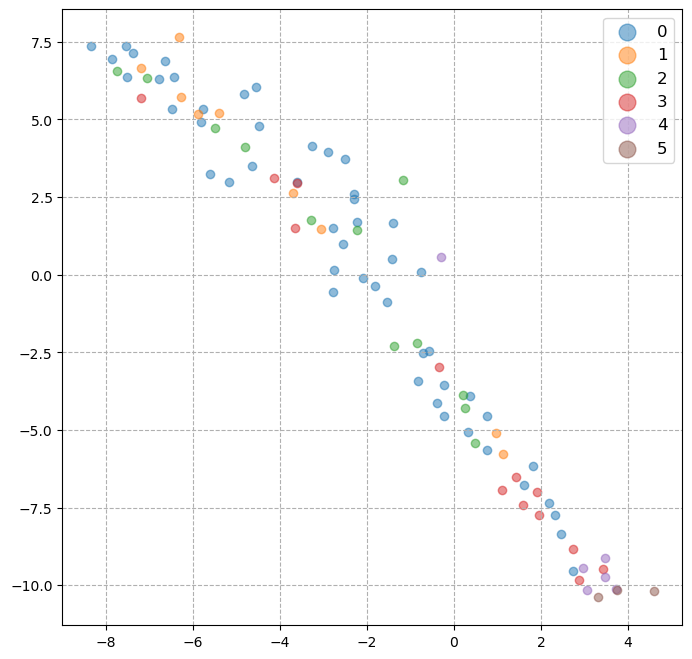

In [16]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=20, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.grid(linestyle='--')
plt.show()

# Plot the preference learning

In [ ]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':1000, 'val':10, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="severity_comparison") for x in ['train', 'val', 'test']}
batch_size = {'train':1, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

In [ ]:
bestsmodel = SeverityModel().to(device)
state_dict = torch.load('./pretrained/best-smodel50-wofreeze-2024-02-25.pt')
bestsmodel.load_state_dict(state_dict)

In [ ]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['test']:
        bestsmodel.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
            ref = torch.stack(ref).to(device)
            output1, output2, refimg = bestsmodel(inputA, inputB, ref)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_targets.append(torch.Tensor([0]))
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, refimg.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

In [ ]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=2000, init='random', perplexity=40, early_exaggeration=50, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Plot the similarity comparison

In [ ]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':1000, 'val':1, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="binary_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':1, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

In [ ]:
bestsimese50simclr = SiameseNetwork101().to(device)
state_dict = torch.load('./pretrained/best-contrastive50-2024-02-25.pt')
bestsimese50simclr.load_state_dict(state_dict)

In [ ]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['train']:
        bestsimese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = bestsimese50simclr(inputA, inputB)
            preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)


In [ ]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=10, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# PLot the feature distances

In [ ]:
from torch import randint
from constants import data_transforms
numberofclasses = glob.glob(f'/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity/test/*')
lenofclass = {}
imagesinclass = {}
for i in range(len(numberofclasses)):
    imagesinclass[i] = glob.glob(numberofclasses[i] + '/*')
    lenofclass[i] = len(glob.glob(numberofclasses[i] + '/*'))

imagesinclass0 = glob.glob(f'/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity/train/0/*')
ref_img = np.array(imagesinclass0)[randint(0, len(imagesinclass0), (100,)).tolist()]
ref_imgs = torch.stack([data_transforms['train'](Image.open(ref_img[i])) for i in range(100)])


In [ ]:
avg_ref_vec = torch.sum(bestsmodel.bestsimese50simclr.cnn1(ref_imgs.to(device)), axis=0)

In [ ]:
embedd = {}
for j in range(len(numberofclasses)):
    temp = torch.stack([data_transforms['test'](Image.open(imagesinclass[j][i])) for i in range(len(imagesinclass[j]))])
    embedd[j] = bestsmodel.bestsimese50simclr.cnn1(temp.to(device))

In [ ]:
cosine_distance = {}
for i in range(6):
    cosine_distance[i] = torch.nn.functional.cosine_similarity(embedd[i].cpu(), avg_ref_vec.cpu())

In [ ]:
for i in range(6):
    plt.scatter(-cosine_distance[i].detach().numpy(), np.ones(lenofclass[i])*i)
plt.grid()
# plt.scatter(cosine_distance[2].detach().numpy(), np.ones(lenofclass[i]) * i)